# Predicting California Wildfires 2013-2018

## Overview

This project's aim is to build a classification model that will predict if there will be a fire in given county over the course of that week. This will be done by using wildfire incidents from [Kaggle](https://www.kaggle.com/ananthu017/california-wildfire-incidents-20132020), and combining it with data about fuel sources by using ground cover data, topography by using elevation data and weather data from CIMIS and Weather Underground. Predicting the weekly probability of wildfires can provide early warning to government groups like CalFire in fighting the spread of wildfires.

## Business Problem

As of early December, there have been more than 9,500 wildfires that have burned more than 4 million acres of California land. California has about 100 million acres, so nearly 4% of California's land has burned from wildfires in the year 2020. This makes 2020 the most destructive year of wildfires recorded in California. Right now the government group CalFire has a [Red Flag and Fire Watch Warning](https://www.fire.ca.gov/programs/communications/red-flag-warnings-fire-weather-watches/) system from the National Weather Service, which is issued during forecasted weather events 24-72 hours in advance, which may result in wildfire behavior. 

There are two types of warnings: a Red Flag Warning and Fire Weather Watches. "A Red Flag Warning is issued for weather events which may result in extreme fire behavior that will occur within 24 hours. A Fire Weather Watch is issued when weather conditions could exist in the next 12-72 hours." Both types of warnings look at weather patterns based on a combinations factors such as low humidity, high wind speeds, dry fuel conditions due to low percipitation and chances of lightning strikes.

The model in this project would predict if a wildfire will occur in a county of California during a specific week based on the three main factors that affect wildfire behavior: weather, topography, and fuels. By running this model at the beginning of each week, CalFire could use the prediction to determine which counties are in most danger of wildfires that week and allocate both funds and personnel to in danger counties. From there, CalFire using the original warning system can prepare there personnel for the days that are most dangerous. This could allow CalFire and associated groups to better prepare and contain wildfires that do occur. 

Another possible benefit would be for alerts to the public of weeks that people should be prepared for possible wildfires, so that they can be prepared for possible evacuations.

## Data Understanding

The data set used in the modeling is gathered from muliple sources. The original wildfire data comes from a [Kaggle](https://www.kaggle.com/ananthu017/california-wildfire-incidents-20132020) data set that had over 1600 different incidents between 2013 and 2020 that the government group CalFire managed the containment of. From this data set, the `acres_burned`, `county`, and `Start` date were used in the final data set. From the `Start` and `county` columns we regrouped the data based on a weekly basis per county and `acres_burned` gave our target variable if there was an indicent in that county and week or not. To help predict the probability of wildfire, we used the features that affect wildfire behavior: Fuel, Topography, and Weather.

The Fuel data was gathered from the [California Land Use and Ownership Portal](https://callands.ucanr.edu/data.html#) by the University of California. Between the years of 2013-2018, each county has a Summary Land Use Statistics csv file for each year. There are 26 different types of land cover, like agriculture use, type of forest, or even barren. All these different files were combined into one dataset that that had number of acres and percentage of county land for each type of landcover. 

The Topography data used the min and max elevations of the counties from the [Anyplace America](https://www.anyplaceamerica.com/directory/ca/) topographic maps.

The Weather Data was gathered from the California Irrigation Management Information System ([CIMIS](https://cimis.water.ca.gov/)) by the California Department of Water Resources and from the [Weather Underground](https://www.wunderground.com/) Website. The daily measurements for the following features were grabbed:

- `Avg Air Temp (F)`
- `Max Air Temp (F)`
- `Min Air Temp (F)`
- `Max Rel Hum (%)`
- `Avg Rel Hum (%)`
- `Min Rel Hum (%)`
- `Dew Point (F)`
- `Avg Wind Speed (mph)`
- `Precip (in)`

For each of the features, the previous week's and previous month's averages were created for the final data set.

Another factor that influences the likelihood of a wildfire occuring is the human population. Many wildfires are due to humans; some of the most common causes are burning debris, unattended camp fires and eletrical lines ([Frontline Wildfire](https://www.frontlinewildfire.com/what-causes-wildfires/)). The data on population and area of the counties was gathered from The California State Association of Counties ([CSAC](https://www.counties.org/data-and-research)).

## Data Prep and Cleaning

To build the final data set for our modeling, we needed to restructure and combine the different data sets into one dataframe.

We first create the final dataframe and add a row for each county for each week between the years 2013-2018.

In [1]:
from Source import CustomLibrary
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 500)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, recall_score, confusion_matrix

In [2]:
final_data = CustomLibrary.county_week()

We then added the fire incidents to the final dataframe.

In [3]:
# Import in the fire incidents as a pandas dataframe
fire_incidents = pd.read_csv('data/California_Fire_Incidents.csv')
# Using custom function, split dataframe into counties and find weekly fire incidents
county_fire_df = CustomLibrary.county_fire(fire_incidents)
# Using custom function, create new dataframe with binary target variable fire_started
fire_started_df = CustomLibrary.fire_started(county_fire_df)
# Merge the target variable dataframe with final dataframe
final_data = pd.merge(final_data, fire_started_df, 
                      how = 'left', 
                      left_on = ['county', 'date'], 
                      right_on = ['county', 'date']);

For the fuel data, all the different county land use statistics need to be restructured and put into one dataframe. For ease, the max elevations and min elevations from topography will be merged here as well.

In [4]:
# Find all the filenames for the ground cover data
files = CustomLibrary.file_names()
# Import the csv files into pandas dataframes
gc_df_list = CustomLibrary.import_ground_cover(files)
# Restructure dataframes and merge into on dataframe
gc_df = CustomLibrary.ground_cover_data(gc_df_list, files)
# Check the first five rows
gc_df.head()

,Alfalfa & Hay_acres,Alfalfa & Hay_percentage,Almonds_acres,Almonds_percentage,Barren_acres,Barren_percentage,Corn_acres,Corn_percentage,Cotton_acres,Cotton_percentage,Deciduous Forest_acres,Deciduous Forest_percentage,Evergreen Forest_acres,Evergreen Forest_percentage,Fallow_acres,Fallow_percentage,Fruit Trees_acres,Fruit Trees_percentage,Grain Crops_acres,Grain Crops_percentage,Grapes_acres,Grapes_percentage,Grassland_acres,Grassland_percentage,High Intensity Developed_acres,High Intensity Developed_percentage,Low Intensity Developed_acres,Low Intensity Developed_percentage,Mixed Forest_acres,Mixed Forest_percentage,Other Ocean/Mexico_acres,Other Ocean/Mexico_percentage,Other Tree Crops_acres,Other Tree Crops_percentage,Other_acres,Other_percentage,Rice_acres,Rice_percentage,Shrubland_acres,Shrubland_percentage,Tomatoes_acres,Tomatoes_percentage,Vegs & Fruits_acres,Vegs & Fruits_percentage,Walnuts_acres,Walnuts_percentage,Water_acres,Water_percentage,Wetlands_acres,Wetlands_percentage,Winter Wheat_acres,Winter Wheat_percentage,county,max_elevation,min_elevation,year
2,1102.856805,0.300074,4.225505,0.001150,194.595625,0.052947,4.670295,0.001271,NaN,NaN,5.337480,0.001452,7838.756565,2.132827,1536.749450,0.418130,1.779160,0.000484,991.214515,0.269697,3722.447510,1.012831,153671.386680,41.812059,28431.421590,7.735834,39470.886995,10.739534,74885.956375,20.375531,NaN,NaN,8.673405,0.002360,NaN,NaN,0.889580,0.000242,30958.051185,8.423298,4.670295,0.001271,164.127510,0.044657,4.670295,0.001271,19403.518960,5.279454,4497.494085,1.223712,624.485160,0.169915,Alameda,1242,-42,2013
2,189.035750,0.040080,NaN,NaN,15482.472715,3.282650,NaN,NaN,NaN,NaN,194.595625,0.041259,195088.007530,41.363269,0.444790,0.000094,0.222395,0.000047,NaN,NaN,NaN,NaN,5644.829890,1.196837,121.427670,0.025746,3192.480225,0.676881,0.667185,0.000141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,247783.390805,52.535935,NaN,NaN,NaN,NaN,NaN,NaN,2650.503610,0.561969,1297.452430,0.275091,NaN,NaN,Alpine,3556,1442,2013
2,1326.808570,0.414290,16.679625,0.005208,1873.010690,0.584840,242.632945,0.075761,NaN,NaN,17190.911105,5.367789,114386.866695,35.716810,168.130620,0.052498,12.009330,0.003750,120.093300,0.037499,2587.343430,0.807887,112912.610240,35.256480,440.119705,0.137425,8263.975805,2.580391,1727.119570,0.539286,NaN,NaN,1.334370,0.000417,NaN,NaN,1.111975,0.000347,52457.865415,16.379744,NaN,NaN,1.779160,0.000556,122.094855,0.038124,5822.745890,1.818128,105.860020,0.033054,479.483620,0.149717,Amador,3121,43,2013
2,3777.156680,0.374865,46196.556585,4.584787,1869.452370,0.185534,2023.349710,0.200808,9.118195,0.000905,33181.556395,3.293111,408193.790775,40.511281,56434.510410,5.600855,10563.317710,1.048359,2628.041715,0.260821,247.525635,0.024566,170758.216925,16.946936,4421.657390,0.438828,25520.048645,2.532743,165.684275,0.016443,NaN,NaN,790.391830,0.078443,NaN,NaN,105624.281300,10.482705,55372.129495,5.495419,94.295480,0.009358,469.475845,0.046593,42057.340845,4.173990,21360.372565,2.119915,11589.893030,1.150241,4257.085090,0.422495,Butte,2192,-1,2013
2,31.802485,0.005011,28.466560,0.004485,218.391890,0.034409,0.889580,0.000140,NaN,NaN,34882.878145,5.495994,255438.004310,40.245698,28.688955,0.004520,12.231725,0.001927,2.223950,0.000350,522.183460,0.082273,207502.763615,32.693230,465.027945,0.073268,12257.745215,1.931277,3351.270255,0.528012,NaN,NaN,0.889580,0.000140,NaN,NaN,NaN,NaN,106091.088405,16.715249,NaN,NaN,0.667185,0.000105,425.664030,0.067066,13178.682910,2.076376,245.079290,0.038614,11.786935,0.001857,Calaveras,3522,787,2013


The fuel dataframe is merged with the final dataframe.

In [5]:
final_data = pd.merge(final_data, gc_df, how = 'left', left_on = ['county', 'year'], right_on = ['county', 'year'])

We want to check for any null values in the final dataframe

In [6]:
final_data.isna().sum()

date                                       0
county                                     0
year                                       0
acres_burned                           17061
fire_started                           17061
Alfalfa & Hay_acres                      261
Alfalfa & Hay_percentage                 261
Almonds_acres                           3860
Almonds_percentage                      3860
Barren_acres                               0
Barren_percentage                          0
Corn_acres                              4230
Corn_percentage                         4230
Cotton_acres                            7358
Cotton_percentage                       7358
Deciduous Forest_acres                   260
Deciduous Forest_percentage              260
Evergreen Forest_acres                     0
Evergreen Forest_percentage                0
Fallow_acres                             420
Fallow_percentage                        420
Fruit Trees_acres                       2346
Fruit Tree

The null values in the fuel section are where there is no particular ground cover in that county. Not all the counties grow the same agricultural produce, thus these null values can be replaced with zero. The null values that occur in the `acres_burned` and `fire_started` columns are due to how the datasets were joined. The fire_started dataframe only has dates for the weeks with wildfire incidents. So when the dataframe was left joined to the final dataframe, which had all the dates from 2013-2018, the missing values were reported as null. To match the binary nature of target variable, the null values will be replaced with zero, which indicates that for that week and county, there were no wildfire incidents.

In [7]:
final_data = final_data.fillna(0)

For the weather data, the specific features need to be gathered from the daily weather data from CIMIS and Weather Underground.

In [8]:
# Use custom function to import CIMIS data and aggregate Past Weeks Weather Averages 
# and Past Months Weather Averages
cimis_pww, cimis_pmw, cimis_files = CustomLibrary.cimis_data()

# Use custom function to import Weather Underground data and aggregate Past Weeks Weather Averages 
# and Past Months Weather Averages
wu_ppw, wu_pmw, wu_files = CustomLibrary.wu_data()

# Use custom function to create a Past Weeks Weather Averages dataframe
pww_df = CustomLibrary.weekly_data(cimis_pww, wu_ppw, cimis_files, wu_files)

# Use custom function to create a Past Months Weather Averages dataframe
pmw_df = CustomLibrary.monthly_data(cimis_pmw, wu_pmw, cimis_files, wu_files)

# Merge the two weather dataframes
weather_df = pd.merge(pww_df, pmw_df, how = 'left', left_on = ['county', 'date'], right_on = ['county', 'date'])

# Merge weather dataframe with the final dataframe
final_data = pd.merge(final_data, weather_df, how = 'left', left_on = ['county', 'date'], right_on = ['county', 'date'])

We check the final dataframe for any null values

In [9]:
final_data.isna().sum()

date                                   0
county                                 0
year                                   0
acres_burned                           0
fire_started                           0
Alfalfa & Hay_acres                    0
Alfalfa & Hay_percentage               0
Almonds_acres                          0
Almonds_percentage                     0
Barren_acres                           0
Barren_percentage                      0
Corn_acres                             0
Corn_percentage                        0
Cotton_acres                           0
Cotton_percentage                      0
Deciduous Forest_acres                 0
Deciduous Forest_percentage            0
Evergreen Forest_acres                 0
Evergreen Forest_percentage            0
Fallow_acres                           0
Fallow_percentage                      0
Fruit Trees_acres                      0
Fruit Trees_percentage                 0
Grain Crops_acres                      0
Grain Crops_perc

There are four missing values in the past week weather features. Due to there small number, the previous value for the column will be used as the value.

In [10]:
final_data = final_data.ffill()

In [11]:
population = pd.read_excel('data/population_by_jurisdiction_and_by_county_-_1970_to_2018_-_09-07-2018.xlsx', 
                          sheet_name = 'Population by County')
area = pd.read_excel('data/datapile_-_headline_datasets_-_current.xlsx', 
                          sheet_name = 'County & Government')

We add the population, area and population density data to the final dataframe. The area is converted from square miles to acres to match the units for ground cover.

In [12]:
# Use custom function to prepare population data for merging with final dataframe
pop_area_df = CustomLibrary.population_data(population, area)
# Merge population dataframe with final dataframe
final_data = pd.merge(final_data, pop_area_df, how = 'left', left_on = ['county', 'year'], right_on = ['county', 'year'])

We check for any duplicates.

In [13]:
final_data.duplicated().sum()

0

## Exploratory Data Analysis

We first take another look at a portion of the data and check the number of columns and their entries. Then check the range of values in the columns.

In [14]:
df = final_data

In [15]:
df.head()

,date,county,year,acres_burned,fire_started,Alfalfa & Hay_acres,Alfalfa & Hay_percentage,Almonds_acres,Almonds_percentage,Barren_acres,Barren_percentage,Corn_acres,Corn_percentage,Cotton_acres,Cotton_percentage,Deciduous Forest_acres,Deciduous Forest_percentage,Evergreen Forest_acres,Evergreen Forest_percentage,Fallow_acres,Fallow_percentage,Fruit Trees_acres,Fruit Trees_percentage,Grain Crops_acres,Grain Crops_percentage,Grapes_acres,Grapes_percentage,Grassland_acres,Grassland_percentage,High Intensity Developed_acres,High Intensity Developed_percentage,Low Intensity Developed_acres,Low Intensity Developed_percentage,Mixed Forest_acres,Mixed Forest_percentage,Other Ocean/Mexico_acres,Other Ocean/Mexico_percentage,Other Tree Crops_acres,Other Tree Crops_percentage,Other_acres,Other_percentage,Rice_acres,Rice_percentage,Shrubland_acres,Shrubland_percentage,Tomatoes_acres,Tomatoes_percentage,Vegs & Fruits_acres,Vegs & Fruits_percentage,Walnuts_acres,Walnuts_percentage,Water_acres,Water_percentage,Wetlands_acres,Wetlands_percentage,Winter Wheat_acres,Winter Wheat_percentage,max_elevation,min_elevation,Avg Air Temp (F)_Weekly,Avg Rel Hum (%)_Weekly,Avg Wind Speed (mph)_Weekly,Dew Point (F)_Weekly,Max Air Temp (F)_Weekly,Max Rel Hum (%)_Weekly,Min Air Temp (F)_Weekly,Min Rel Hum (%)_Weekly,Precip (in)_Weekly,Avg Air Temp (F)_month,Avg Rel Hum (%)_month,Avg Wind Speed (mph)_month,Dew Point (F)_month,Max Air Temp (F)_month,Max Rel Hum (%)_month,Min Air Temp (F)_month,Min Rel Hum (%)_month,Precip (in)_month,Population,county_acres,pop_density
0,2013-01-06,Alameda,2013,0.0,0.0,1102.856805,0.300074,4.225505,0.001150,194.595625,0.052947,4.670295,0.001271,0.000000,0.000000,5.337480,0.001452,7838.756565,2.132827,1536.749450,0.418130,1.779160,0.000484,991.214515,0.269697,3722.447510,1.012831,153671.386680,41.812059,28431.421590,7.735834,39470.886995,10.739534,74885.956375,20.375531,0.0,0.0,8.673405,0.002360,0.0,0.0,0.889580,0.000242,30958.051185,8.423298,4.670295,0.001271,164.127510,0.044657,4.670295,0.001271,19403.518960,5.279454,4497.494085,1.223712,624.485160,0.169915,1242,-42,44.214286,82.785714,2.392857,39.321429,54.157143,96.500000,35.771429,60.785714,0.095714,45.506897,78.189655,2.915517,38.932759,55.896552,95.448276,35.725862,55.810345,0.130172,1567167,528000,2.968119
1,2013-01-06,Alpine,2013,0.0,0.0,189.035750,0.040080,0.000000,0.000000,15482.472715,3.282650,0.000000,0.000000,0.000000,0.000000,194.595625,0.041259,195088.007530,41.363269,0.444790,0.000094,0.222395,0.000047,0.000000,0.000000,0.000000,0.000000,5644.829890,1.196837,121.427670,0.025746,3192.480225,0.676881,0.667185,0.000141,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,247783.390805,52.535935,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2650.503610,0.561969,1297.452430,0.275091,0.000000,0.000000,3556,1442,29.657143,76.514286,3.228571,21.328571,34.428571,91.857143,22.857143,55.428571,0.000000,30.789655,68.162069,4.968966,19.600000,39.344828,86.000000,22.758621,46.344828,0.000000,1164,465280,0.002502
2,2013-01-06,Amador,2013,0.0,0.0,1326.808570,0.414290,16.679625,0.005208,1873.010690,0.584840,242.632945,0.075761,0.000000,0.000000,17190.911105,5.367789,114386.866695,35.716810,168.130620,0.052498,12.009330,0.003750,120.093300,0.037499,2587.343430,0.807887,112912.610240,35.256480,440.119705,0.137425,8263.975805,2.580391,1727.119570,0.539286,0.0,0.0,1.334370,0.000417,0.0,0.0,1.111975,0.000347,52457.865415,16.379744,0.000000,0.000000,1.779160,0.000556,122.094855,0.038124,5822.745890,1.818128,105.860020,0.033054,479.483620,0.149717,3121,43,34.114286,83.571429,3.157143,29.585714,40.071429,96.000000,27.757143,66.571429,0.141429,34.289655,76.724138,3.606897,27.410345,41.200000,93.172414,27.768966,58.310345,0.155517,37304,384640,0.096984
3,2013-01-06,Butte,2013,0.0,0.0,3777.156680,0.374865,46196.556585,4.584787,1869.452370,0.185534,2023.349710,0.200808,9.118195,0.000905,33181.556395,3.293111,408193.790775,40.511281,56434.510410,5.600855,10563.317710,1.048359,2628.041

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18154 entries, 0 to 18153
Data columns (total 80 columns):
date                                   18154 non-null datetime64[ns]
county                                 18154 non-null object
year                                   18154 non-null int64
acres_burned                           18154 non-null float64
fire_started                           18154 non-null float64
Alfalfa & Hay_acres                    18154 non-null float64
Alfalfa & Hay_percentage               18154 non-null float64
Almonds_acres                          18154 non-null float64
Almonds_percentage                     18154 non-null float64
Barren_acres                           18154 non-null float64
Barren_percentage                      18154 non-null float64
Corn_acres                             18154 non-null float64
Corn_percentage                        18154 non-null float64
Cotton_acres                           18154 non-null float64
Cotton_percentage  

In [17]:
df.describe()

,year,acres_burned,fire_started,Alfalfa & Hay_acres,Alfalfa & Hay_percentage,Almonds_acres,Almonds_percentage,Barren_acres,Barren_percentage,Corn_acres,Corn_percentage,Cotton_acres,Cotton_percentage,Deciduous Forest_acres,Deciduous Forest_percentage,Evergreen Forest_acres,Evergreen Forest_percentage,Fallow_acres,Fallow_percentage,Fruit Trees_acres,Fruit Trees_percentage,Grain Crops_acres,Grain Crops_percentage,Grapes_acres,Grapes_percentage,Grassland_acres,Grassland_percentage,High Intensity Developed_acres,High Intensity Developed_percentage,Low Intensity Developed_acres,Low Intensity Developed_percentage,Mixed Forest_acres,Mixed Forest_percentage,Other Ocean/Mexico_acres,Other Ocean/Mexico_percentage,Other Tree Crops_acres,Other Tree Crops_percentage,Other_acres,Other_percentage,Rice_acres,Rice_percentage,Shrubland_acres,Shrubland_percentage,Tomatoes_acres,Tomatoes_percentage,Vegs & Fruits_acres,Vegs & Fruits_percentage,Walnuts_acres,Walnuts_percentage,Water_acres,Water_percentage,Wetlands_acres,Wetlands_percentage,Winter Wheat_acres,Winter Wheat_percentage,max_elevation,min_elevation,Avg Air Temp (F)_Weekly,Avg Rel Hum (%)_Weekly,Avg Wind Speed (mph)_Weekly,Dew Point (F)_Weekly,Max Air Temp (F)_Weekly,Max Rel Hum (%)_Weekly,Min Air Temp (F)_Weekly,Min Rel Hum (%)_Weekly,Precip (in)_Weekly,Avg Air Temp (F)_month,Avg Rel Hum (%)_month,Avg Wind Speed (mph)_month,Dew Point (F)_month,Max Air Temp (F)_month,Max Rel Hum (%)_month,Min Air Temp (F)_month,Min Rel Hum (%)_month,Precip (in)_month,Population,county_acres,pop_density
count,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,1.815400e+04,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,1.815400e+04,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,1.815400e+04,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,1.815400e+04,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,18154.000000,1.815400e+04,1.815400e+04,18154.000000
mean,2015.504792,290.232401,0.060207,24570.424702,2.003151,21117.333652,1.604569,7.912427e+04,2.261803,3361.109941,0.487368,4301.021027,0.299834,8721.068583,0.943632,3.583280e+05,24.659339,28732.768640,2.576118,6684.375969,0.423007,12393.999700,1.138298,14699.487910,1.135835,1.899408e+05,16.148044,29282.398944,3.080043,55036.139529,5.065425,30109.664401,3.599637,543.563136,0.136258,5729.514633,0.281947,460.246269,0.123428,8496.502065,1.438587,7.230996e+05,27.896110,4786.157442,0.502587,5903.129910,0.382318,7075.275829,0.905611,16105.280443,1.250698,9558.657253,1.012787,6877.897718,0.632848,2234.293103,177.568966,59.500787,61.311253,4.934522,44.036920,73.454869,84.207783,46.880363,38.882119,0.039067,59.490712,61.293238,4.942224,44.014769,73.446804,84.200918,46.870562,38.859696,0.039071,6.732122e+05,1.751095e+06,0.832761
std,1.707242,6492.129448,0.237877,40225.018677,3.263930,49383.509905,3.303131,2.110837e+05,4.160180,8607.274795,1.400160,15051.203943,1.396754,12558.740032,1.658224,4.729540e+05,23.872315,55356.367026,4.962582,20126.287513,0.871029,23313.919454,2.154025,34616.473316,2.206399,2.030533e+05,12.824473,104775.403842,7.999534,75105.921991,6.314707,47163.681669,5.883815,4896.533721,1.214836,18947.612638,0.858020,4589.752379,1.134029,26293.910360,4.767195,1.584942e+06,21.515792,13830.499485,1.204872,16069.686764,0.715188,14845.856636,2.149516,28610.599989,1.369898,14670.268921,1.913291,13477.777082,1.

It is important to check the number of weeks that have wildfires started and those that don't.

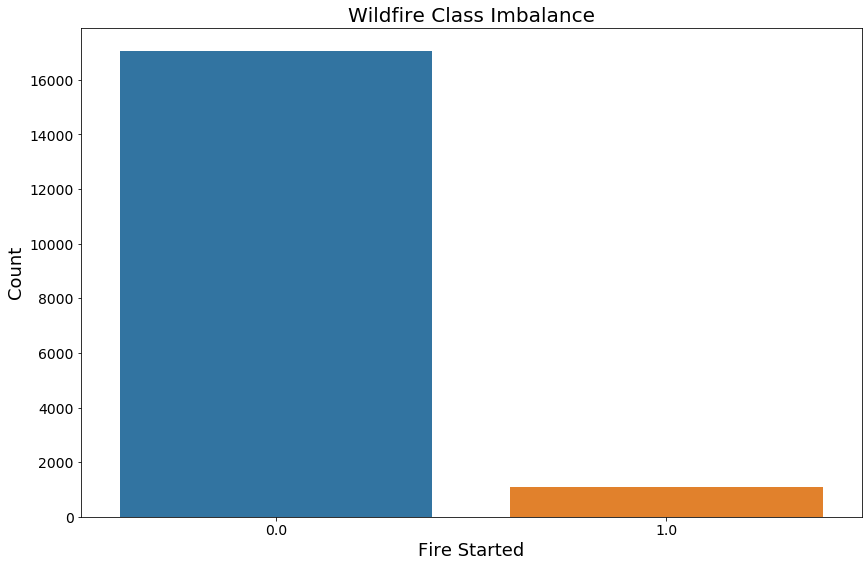

In [18]:
plt.figure(figsize = [14, 9])
sns.countplot(df.fire_started)
plt.title('Wildfire Class Imbalance', fontsize = 20)
plt.xlabel('Fire Started', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.savefig('images/class_imbalance.png', bbox_inches='tight');

As expected, there is a large class imbalance between the number of weeks that have a wildfire starting and the weeks that don't.

Next we checked the number wildfires through the year. We use only one year to get a clearer idea of possible high points.

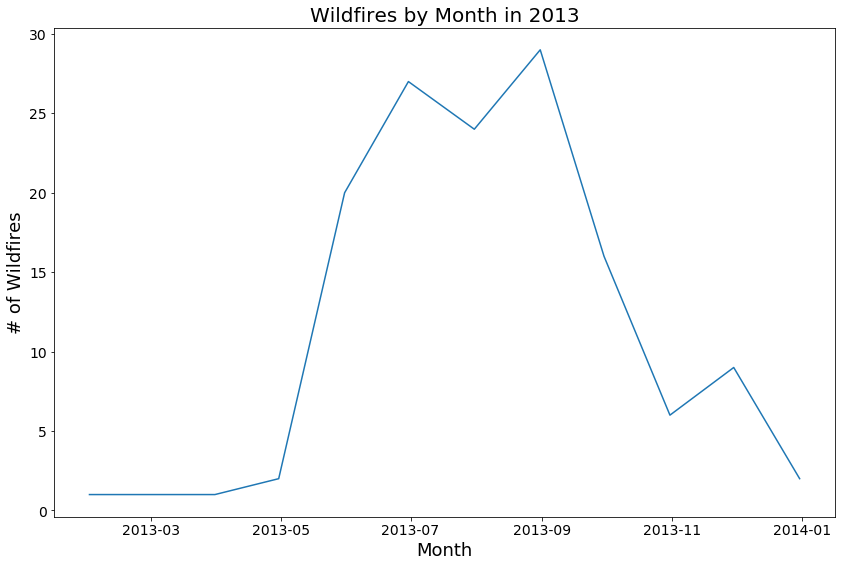

In [19]:
plt.figure(figsize = [14, 9])
year_ex = CustomLibrary.year_example(df)
plt.plot(year_ex['date'], year_ex.fire_started)
plt.title('Wildfires by Month in 2013', fontsize = 20)
plt.xlabel('Month', fontsize=18)
plt.ylabel('# of Wildfires', fontsize=18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.savefig('images/year_ex.png', bbox_inches='tight');

There are more wildfires starting in the summer months than the rest of the year. This makes sense as the summer months are drier and with less rain.

We create a month feature to take a closer look at the number of wildfires started based on month.

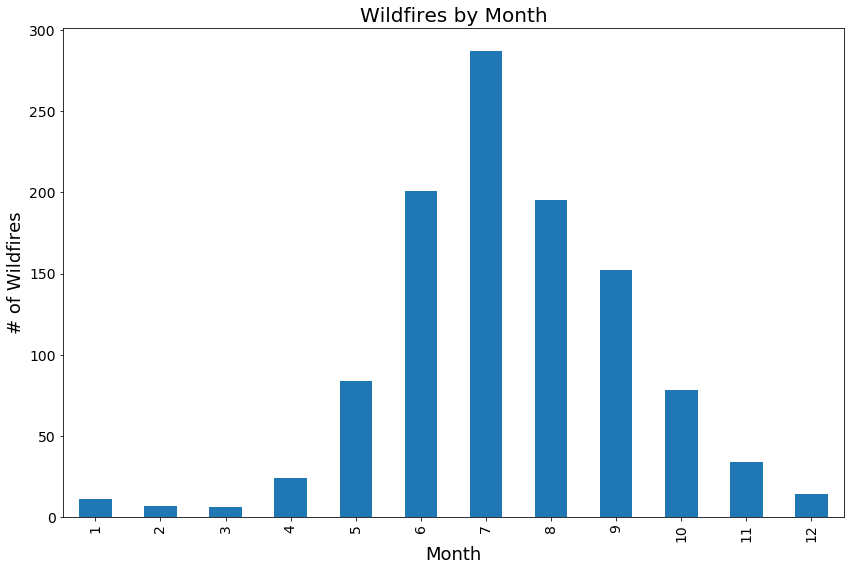

In [20]:
# Create new feature for month of the year
df['month'] = pd.DatetimeIndex(df.date).month
# Group the dataframe by month and the sum of the fires started
month_gpby = df.groupby('month')['fire_started'].sum()
# Plot grouped dataframe
plt.figure(figsize = [14, 9])
month_gpby.plot(kind = 'bar')
plt.title('Wildfires by Month', fontsize = 20)
plt.xlabel('Month', fontsize=18)
plt.ylabel('# of Wildfires', fontsize=18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.savefig('images/wildfires_month.png', bbox_inches='tight');

As seen in the year 2013, over the course of 2013-2018 the majority of wildfires start in the summer months. July is the month that has the most wildfires started.

Next we check if there are certain years that have more wildfires than others.

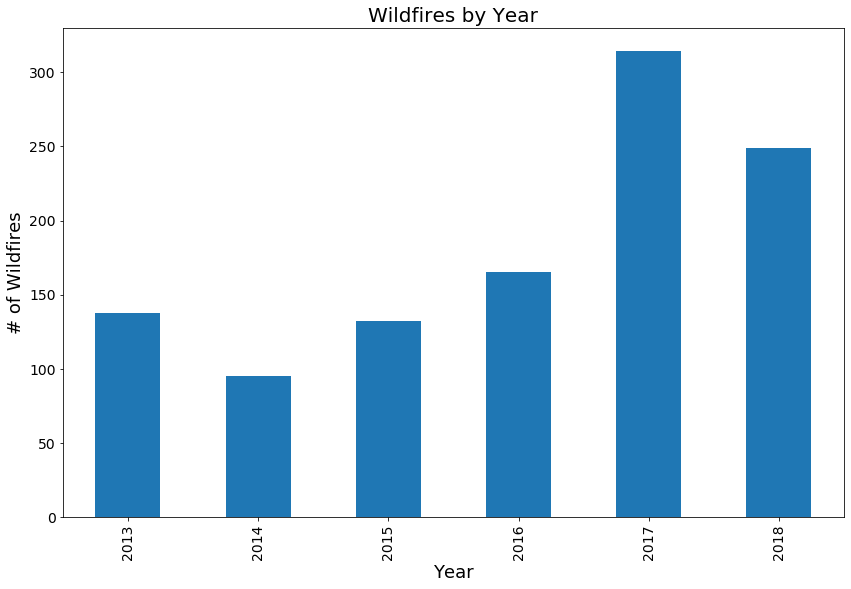

In [21]:
# Group fires started by year
year_gpby = df.groupby('year')['fire_started'].sum()
# Plot grouped dataframe
plt.figure(figsize = [14, 9])
year_gpby.plot(kind = 'bar')
plt.title('Wildfires by Year', fontsize = 20)
plt.xlabel('Year', fontsize=18)
plt.ylabel('# of Wildfires', fontsize=18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.savefig('images/wildfires_years.png', bbox_inches='tight');

After the decrease after 2013, there seems to be an increasing trend of wildfires that Calfire managed the containment of.

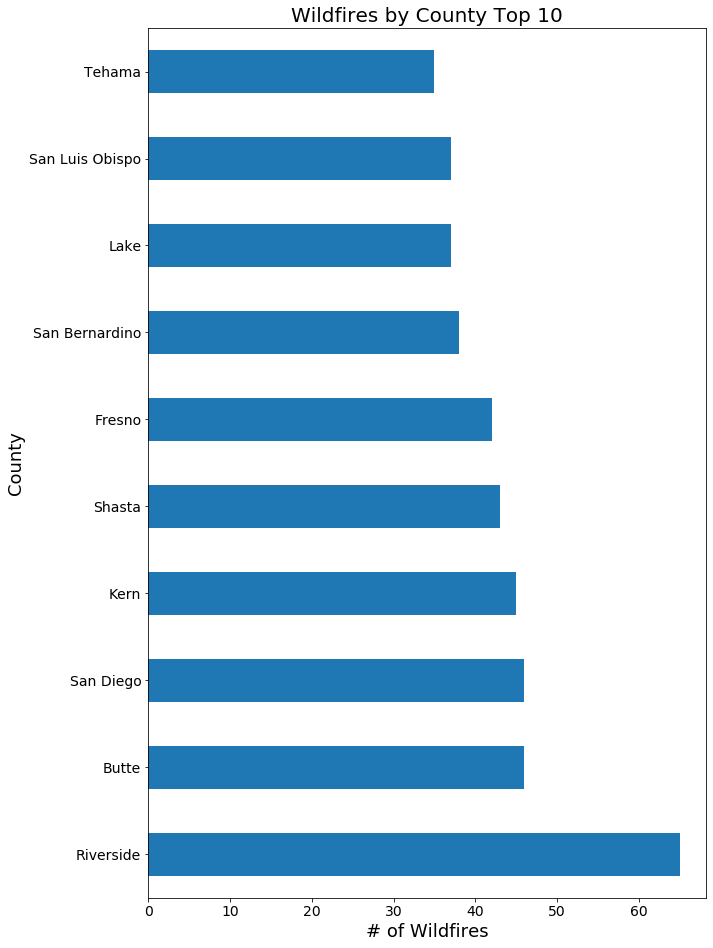

In [22]:
# Group fires by county
county_gpby = df.groupby('county')['fire_started'].sum().sort_values(ascending = False)
# Plot grouped dataframe
plt.figure(figsize = [14, 9])
county_gpby[0:10].plot(kind = 'barh', figsize = (10, 16))
plt.title('Wildfires by County Top 10', fontsize = 20)
plt.ylabel('County', fontsize=18)
plt.xlabel('# of Wildfires', fontsize=18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.savefig('images/wilfires_county.png', bbox_inches='tight');

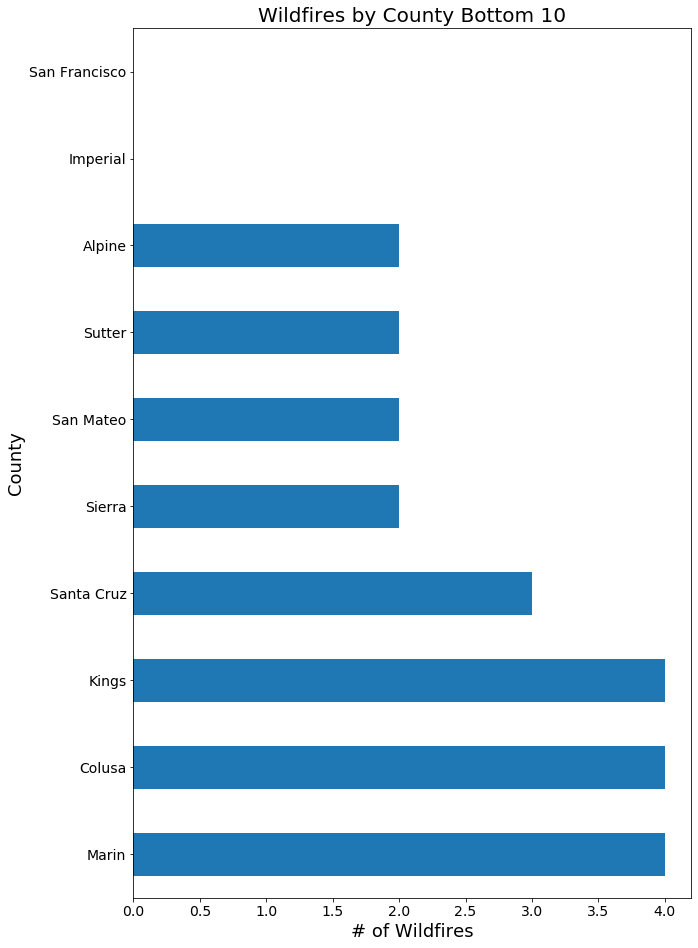

In [23]:
# Group fires by county
county_gpby = df.groupby('county')['fire_started'].sum().sort_values(ascending = False)
# Plot grouped dataframe
plt.figure(figsize = [14, 9])
county_gpby[-10:].plot(kind = 'barh', figsize = (10, 16))
plt.title('Wildfires by County Bottom 10', fontsize = 20)
plt.ylabel('County', fontsize=18)
plt.xlabel('# of Wildfires', fontsize=18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.savefig('images/wilfires_county_bottom10.png', bbox_inches='tight');

There are certain counties that are more likely to have more wildfires than others. The county of Riverside has had the highest number of wilfires started.

## Modeling

### Modeling Strategies and Model Findings

1. Due to the heavy class imbalance, after splitting the dataframe into train and test datasets, the training data, the minority class (wildfire) was upsampled to match the presence of the majority class (no wildfire)
<br>
<br>
2. Created a baseline model for logistic regression, K Nearest Neighbor (KNN), Decision Tree, and Random Forest
    - The baseline models were models trained on their default settings.
<br>
<br>
3. The most important metrics studied were recall and accuracy. 
    - Recall was chosen due to the dangers of wildfires. We want to minimize the number of false negatives, which in this case would be predicting that there will not be a wildfire in a given county during a specific week. There could be more damage and loss of life for predicted false negatives, while a false positive would be having personnel prepared to fight wildfires.
    - Accuracy was chosen because while reducing the number of false negatives is most important, we did not want to allow the number of false positives to increase dramatically in efforts to increase the recall score.
    - To account for this, the f1 score was used to help increase the recall score, without the accuracy dropping too much.
<br>
<br>
4. Tuning Models:
    - The logistic model was also tested on scaled training features. cross_val_score was used for validation of these models.
    - The KNN model was tuned by finding the best k value for parameter `n_neighbors`. cross_val_score was used for validation.
    - GridSearchCV was used to tune the decision tree and random forest models.
        - The decision tree was tuned on `max_depth`, `max_features`, and `min_samples_split`
        - The random forest classifier was tuned on `n_estimators`, `criterion`, `max_features`, and `min_samples_split`.
        - Both base models were highly overfit. The parameters `max_depth` and `min_samples_split` were used to reduce overfitting.
<br>
<br>
5. The best models were the logistic regression with scaled features and the random forest classifier.

### Dummy Variables

There are two categorical columns in the dataframe: `month` and `county`. We use `pandas.get_dummies()` to work with the categorical values.

In [24]:
df2 = CustomLibrary.dummy_variables(df)

### Train-Test Split

In [25]:
y = df2.fire_started
X = df2.drop(columns = ['fire_started'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X,  y, test_size = 0.25, random_state = 0)

### Import pickled models

#### Logistic Regression

In [26]:
import pickle

In [27]:
with open("models/best_logistic.pickle", "rb") as best_logistic:
    logreg_model = pickle.load(best_logistic)

with open("models/ss.pickle", "rb") as standard_scaler:
    ss = pickle.load(standard_scaler)

In [28]:
X_test_scaled = ss.transform(X_test)
y_pred_log = logreg_model.predict(X_test_scaled)
recall_log = recall_score(y_test, y_pred_log)
accuracy_log = accuracy_score(y_test, y_pred_log)
print('Recall Score:', recall_log, 'Accuracy Score:', accuracy_log)

Recall Score: 0.803448275862069 Accuracy Score: 0.7428949107732981


#### K Nearest Neighbor (KNN)

In [29]:
with open("models/best_knn.pickle", "rb") as best_knn:
    knn_model = pickle.load(best_knn)

In [30]:
y_pred_knn = knn_model.predict(X_test_scaled)
recall_knn = recall_score(y_test, y_pred_knn)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print('Recall Score:', recall_knn, 'Accuracy Score:', accuracy_knn)

Recall Score: 0.7413793103448276 Accuracy Score: 0.7131526768010575


#### Decision Tree

In [31]:
with open("models/best_decision_tree.pickle", "rb") as best_decision_tree:
    dt_model = pickle.load(best_decision_tree)

In [32]:
y_pred_dt = dt_model.predict(X_test)
recall_dt = recall_score(y_test, y_pred_dt)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print('Recall Score:', recall_dt, 'Accuracy Score:', accuracy_dt)

Recall Score: 0.7482758620689656 Accuracy Score: 0.7290152015862524


#### Random Forest

In [33]:
with open("models/best_random_forest.pickle", "rb") as best_random_forest:
    rfc_model = pickle.load(best_random_forest)

In [34]:
y_pred_rfc = rfc_model.predict(X_test)
recall_rfc = recall_score(y_test, y_pred_rfc)
accuracy_rfc = accuracy_score(y_test, y_pred_rfc)
print('Recall Score:', recall_rfc, 'Accuracy Score:', accuracy_rfc)

Recall Score: 0.7517241379310344 Accuracy Score: 0.762502753910553


#### Adaboost Classifier

In [35]:
with open("models/best_adaboost.pickle", "rb") as best_adaboost:
    adaboost_model = pickle.load(best_adaboost)

In [36]:
y_pred_adaboost = adaboost_model.predict(X_test)
recall_adaboost = recall_score(y_test, y_pred_adaboost)
accuracy_adaboost = accuracy_score(y_test, y_pred_adaboost)
print('Recall Score:', recall_adaboost, 'Accuracy Score:', accuracy_adaboost)

Recall Score: 0.7724137931034483 Accuracy Score: 0.7495042961004627


#### Gradient Boosting

In [37]:
with open("models/best_gradientboosting.pickle", "rb") as best_gradientboosting:
    gbt_model = pickle.load(best_gradientboosting)

In [38]:
y_pred_gbt = gbt_model.predict(X_test)
recall_gbt = recall_score(y_test, y_pred_gbt)
accuracy_gbt = accuracy_score(y_test, y_pred_gbt)
print('Recall Score:', recall_gbt, 'Accuracy Score:', accuracy_gbt)

Recall Score: 0.7586206896551724 Accuracy Score: 0.7706543291473893


#### XGBoosting Classifier

In [39]:
with open("models/best_xgb.pickle", "rb") as best_xgb:
    xgb_model = pickle.load(best_xgb)

In [40]:
y_pred_xgb = xgb_model.predict(X_test)
recall_xgb = recall_score(y_test, y_pred_xgb)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print('Recall Score:', recall_xgb, 'Accuracy Score:', accuracy_xgb)

Recall Score: 0.7689655172413793 Accuracy Score: 0.751487111698612


## Evaluation

The best model is the logistic regression. While all the models had very close recall scores, the logistic regression model was slightly higher with a score of ~80%.

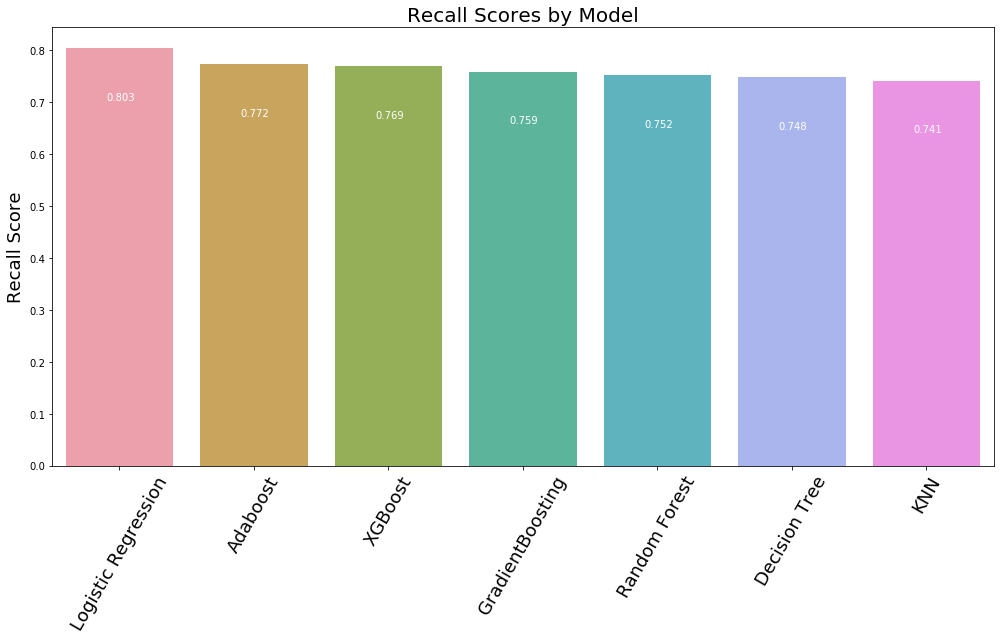

In [41]:
CustomLibrary.model_recall_scores_viz(recall_log, recall_knn, recall_dt, recall_rfc, 
                                      recall_adaboost, recall_gbt, recall_xgb)

From the confusion matrix, we can see that while the number of false negatives was smaller, the number of false positives was very large.

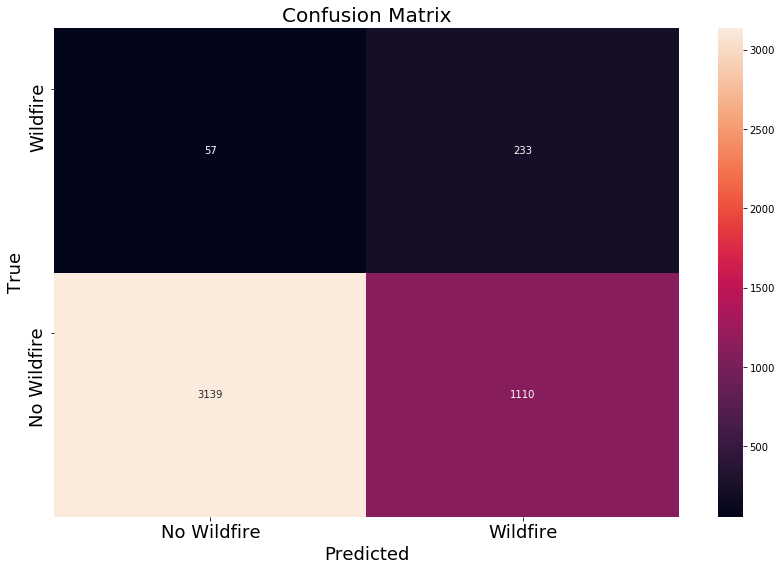

In [42]:
CustomLibrary.confusion_matrix_viz(y_test, y_pred_log)

## Conclusion

With a recall score of over 80%, it means that this model for every 5 observations that result in a wilfire starting, it incorrectly predicts one of those observations as a week with no wildfires. While the model does well at catching which observations will result in wildfires, the model should ideally have a higher recall score. A possible reason for the false negatives could be from missing connections. One of the most common causes for wildfires are electrical lines. This model has not taken into account how eletrical lines might increase the chance of wildfires. The large number of false positives could also be from missing connections or it might be due to the nature of CalFire Wildfire Incidents that only record wildfires that burn more than 10 acres. A portion of the false positives could be from wildfires that burned close to 10 acres but did not reach the cutoff.

This model can be used at the start of each week, so that groups like CalFire can allocate both funds and personnel to higher risk counties in preparation of Red Flags or Fire Watch Warnings. With wildfires only greater than 10 acres recorded, this will give government groups and citizens of counties more information and awareness about the possibility of a larger wildfire. From there groups like Calfire can be more prepared to contain the wildfires and citizens can prep for possible evacuations.

## Future Steps

Possible future improvements to this project are: 

    - More feature engineering. After gathering easily accesible revelant data, finding different connections or creating new features from other columns could increase the accuracy even more.
    - Gathering more human relevant data such as age of electrical grid and industries. Some of the more common causes of wildfires are from electrical lines causing sparks or from industrial factories causing the sparks.
    
Further study could model the classification of fire sizes using the number of acres burned. As of now, the model predicts which weeks a county will have a wildfire incident, while classifying the wildfires by their size, would give CalFire and other groups even more information about how big certain fires will be.